## <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Heartbeat Anomoly Detection Using Heart Beat Sound</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">HCI J Component
    </center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Vidyarth G S 20BCE0150</center>

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Sivanesh K 20BCE0153</center>


<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #eeeeee; font-size:100%; text-align:left">

<h3 align="left"><font color='#000000'>💡 Problem Statement and Data Source :</font></h3>

[Challenge](https://istethoscope.peterjbentley.com/heartchallenge/index.html)

Data from: [Dataset main](https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds) + [Secondary Class organised](https://www.kaggle.com/datasets/abdallahaboelkhair/heartbeat-sound)

<h4> Problem Statement </h4>

The task is to produce a method that can classify real heart audio (also known as “beat classification”) into one of five categories:

* Normal
* Murmur
* Extrasystole
* Artifact
* Extrahls

### <p style="font-family:JetBrains Mono; font-weight:bolder; letter-spacing: 2px; color:#000000; font-size:140%; text-align:left;padding: 0px;"> 🫀 Our Work</p>

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #EEEEEE; font-size:100%; text-align:left">
<h3 align="left"><font color='#000000'> 📊 Exploratory Data Analysis: </font></h3>
    
<h4>Studing the data and its distribution.</h4>

1. Waveform / Spectrum
2. Frequency distribution using Fourier Transform
3. Spectrogram 
4. MFCCs
5. Comparing Patterns


<h3 align="left"><font color='#000000'> 🔧 Audio signal preprocessing: </font></h3>
 
1. Duration clipping
2. Low Pass Filterring in Frequency Domain
3. Feature Extraction using MFCC, Chroma shift, roll off etc.
4. Label Encoding
5. Multicollinearity
6. Scalling
7. Test Train Split

In [1]:
!pip install librosa
!pip install resampy
!pip install seaborn

^C


In [6]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
import os
import glob
import numpy as np
import math
import itertools
import pandas as pd 
import fnmatch

from scipy.io import wavfile
import librosa, librosa.display
import IPython.display as ipd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#000000; font-size:140%; text-align:left;padding: 0px;"> 📊 EDA</p>

In [19]:
metadataA= pd.read_csv("/kaggle/input/heartbeat-sounds/set_a.csv")

In [20]:
metadataA.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


In [25]:
metadataA.label.value_counts()

label
artifact    40
murmur      34
normal      31
extrahls    19
Name: count, dtype: int64

In [26]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=metadataA["label"] , marker_color="#DC143C"))
fig.update_layout(
    title="Meta data A",
    xaxis_title="Classes",
    yaxis_title="Count",
)

fig.show()

In [27]:
metadataA.isnull().sum()

dataset       0
fname         0
label        52
sublabel    176
dtype: int64

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #EEEEEE; font-size:100%; text-align:left">

<h3 align="left"><font color='#000000'>💡 Notes:</font></h3>

We have 52 unlabelled target columns

In [33]:
if "sublabel" in metadataA.columns:
    metadataA.drop("sublabel", inplace=True)


In [34]:
metadataA.shape

(176, 3)

In [36]:
metadataB = pd.read_csv("/kaggle/input/heartbeat-sounds/set_b.csv")

In [37]:
metadataB.head()

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN


In [38]:
metadataB.label.value_counts()

label
normal        320
murmur         95
extrastole     46
Name: count, dtype: int64

In [39]:
metadataB.isnull().sum()

dataset       0
fname         0
label       195
sublabel    507
dtype: int64

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #EEEEEE; font-size:100%; text-align:left">

<h3 align="left"><font color='#000000'>💡 Notes:</font></h3>

* We have 195 unlabelled target columns

In [40]:
metadataB.drop("sublabel", axis =1, inplace=True)

In [41]:
metadataB.shape

(656, 3)

In [42]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=metadataB["label"] , marker_color="#DC143C"))
fig.update_layout(
    title="Meta data B",
    xaxis_title="Classes",
    yaxis_title="Count",
)

fig.show()

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #EEEEEE; font-size:100%; text-align:left">
<h3 align="left"><font color='#0000'>💡 Taking audio files of length greater than 4 seconds only !</font></h3>
    

In [43]:
dataset = []
for folder in ["../input/heartbeat-sounds/set_a/**","../input/heartbeat-sounds/set_b/**"]:
    for filename in glob.iglob(folder):         #Compares file pattern in folder to what is being fed
        if os.path.exists(filename):         
            label = os.path.basename(filename).split("_")[0]       #takes the label out, if you notice, you will realie
# skip audio smaller than 4 secs
       # if librosa.get_duration(filename=filename)>=4:
        if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
            dataset.append({
                            "filename": filename,
                            "label": label
                          })

df = pd.DataFrame(dataset)
df = shuffle(df, random_state=42)

In [44]:
df2 = pd.concat([metadataA.dropna(),metadataB.dropna()])

In [45]:
df2.shape

(585, 3)

In [46]:
df.shape 

(585, 2)

In [47]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df["label"] , marker_color="#CD5C5C"))
fig.update_layout(
    title="Audio Distribution Combined",
    xaxis_title="Classes",
    yaxis_title="Count" 
)

fig.show()


In [48]:
df.shape

(585, 2)

In [49]:
dataset = []
for folder in ["../input/heartbeat-sounds/set_a/**","../input/heartbeat-sounds/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
# skip audio smaller than 4 secs
        if librosa.get_duration(filename=filename)>=4:
            if label not in ["Aunlabelledtest", "Bunlabelledtest"]:       #we remove the NaN values
                dataset.append({
                                "filename": filename,
                                "label": label
                              })

df = pd.DataFrame(dataset)
df = shuffle(df, random_state=42)

In [50]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df["label"] , marker_color="#CD5C5C"))
fig.update_layout(
    title="Audio Distribution Combined",
    xaxis_title="Classes",
    yaxis_title="Count"    
)

fig.data[0].hovertext = "Count: " + df["label"].value_counts().to_string()

fig.show()

In [51]:
df.shape

(404, 2)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#000000; font-size:140%; text-align:left;padding: 0px;">💽 Understanding Audio Data</p>

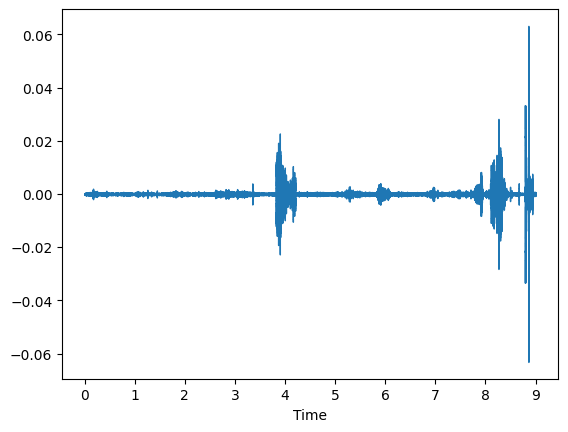

In [52]:
data,frame=librosa.load('/kaggle/input/heartbeat-sounds/set_a/Aunlabelledtest__201012172010.wav')
librosa.display.waveshow(data,sr=
                         frame)
ipd.Audio('/kaggle/input/heartbeat-sounds/set_a/Aunlabelledtest__201012172010.wav')

<div style="border-radius:10px; border:#000000 solid; padding: 15px; background-color: #eeeeee; font-size:100%; text-align:left">
<h3 align="left"><font color='#000000'>💡 Sampling Rate:</font></h3>

* **The rate at which the audio data is split into samples based on the time period.**
    
* In real time, the signals are taken continuously (known as analog), but the analysis and processing are done indiscrete (known as digital).
    
* So the conversion of signal from continuous to discrete is
  called as sampling.

* There is a rate at which the sampling is done, if it is too 
  less then there will be data loss because the sampled
  signal might not contain all the information of the original
  signal.
    
* If the rate is too high, it will take a lot of resource and time for processing. The ideal sampling rate is twice the frequency of t maximum component in the signal **(Nyquist thorem)**.


In [53]:
frame

22050

**[<h1>💽EDA](https://www.kaggle.com/arghyapaul/eda-part)**

# How we feature extract?

- MFCCs (Mel-Frequency Cepstral Coefficients)

Its important to keep in mind that more we put the n_mfcc's more the amount of features we will get. we should aim to get a good amount but also not overbombard our model with too many features as it **increase the extract as well as train time to handle that many features.**


- MFCCs capture spectral characteristics of an audio signal and are particularly useful for audio classification tasks. They represent the **short-term power spectrum of sound.**

In [54]:
ad, sr_demo = librosa.load('/kaggle/input/heartbeat-sounds/set_a/Aunlabelledtest__201012172010.wav')

In [55]:
ad

array([-1.3300074e-04, -3.8742459e-05,  1.9526234e-04, ...,
        9.4768227e-05, -3.0561780e-05,  6.3747764e-05], dtype=float32)

In [56]:
mfcc_features = librosa.feature.mfcc(y=ad, sr=sr_demo, n_mfcc=120)

In [57]:
mfcc_features

array([[-7.06924316e+02, -6.67949585e+02, -6.70877014e+02, ...,
        -5.00196930e+02, -5.76922363e+02, -6.37969299e+02],
       [ 2.81231689e+01,  2.85532188e+01,  2.51491470e+01, ...,
         1.21713936e+02,  9.57189178e+01,  6.39696159e+01],
       [-1.64409103e+01, -1.27459259e+01, -1.68281746e+01, ...,
        -1.69453697e+01, -1.15862894e+01, -3.65353775e+00],
       ...,
       [-6.54792070e-01,  2.04109788e-01, -4.20506001e-02, ...,
         1.06477880e+00,  1.50218415e+00,  2.73750091e+00],
       [ 6.09621048e-01, -4.18885708e-01, -7.47130394e-01, ...,
         3.77946377e-01, -4.31340933e-01, -5.65829754e-01],
       [ 8.28670144e-01, -6.72820091e-01,  3.25356245e-01, ...,
        -5.70309877e-01, -1.47344828e+00, -3.71621847e+00]], dtype=float32)

<h2> Streching for Data Augmentation </h2>

When **Shrink** and **Strech** our audio by multiplying it by a factor of 0.8 and 1.2 respectively so that our model is more robust as it is expoused to some disturbance of the same features.

<h3>Zero Crossing Rate</h3>
Zero Crossing Rate measures the rate at which an audio signal changes its sign. It can indicate the presence of silence regions (few zero crossings) or speech regions (more zero crossings) in the signal.

<h3>Spectral Centroid</h3>
Spectral Centroid provides information about the dominant frequency components in an audio signal. It can be used to characterize the "center of mass" of the spectrum.

<h3>Spectral Rolloff</h3>
Spectral Rolloff is a measure of the frequency below which a specified percentage (e.g., 85% or 95%) of the total spectral energy lies. It can help identify the high-frequency content in the audio.

<h3>Chroma Features</h3>
Chroma features represent the 12 different pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, B) in an audio signal. They are useful for analyzing the harmonic content and musical characteristics of the audio.


| Feature Name | Use Description | Example Code |
| --- | --- | --- |
| **MFCC (Mel-Frequency Cepstral Coefficients)** | Capture spectral characteristics, useful for audio classification. | `mfcc_features = np.mean(librosa.feature.mfcc(y=x_filtered, sr=sr, n_mfcc=120), axis=1)` |
| **Zero Crossing Rate** | Indicates the presence of silence and speech regions. | `zero_crossings = np.mean(librosa.feature.zero_crossing_rate(x_filtered))` |
| **Spectral Centroid** | Describes the dominant frequency components in the audio signal. | `spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=x_filtered, sr=sr))` |
| **Spectral Rolloff** | Measures the frequency below which a specified percentage of spectral energy lies. | `spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=x_filtered, sr=sr))` |
| **Chroma Features** | Represents the 12 different pitch classes. | `chroma_stft = np.mean(librosa.feature.chroma_stft(y=x_filtered, sr=sr))` |



In [58]:

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs                                 
    normal_cutoff = cutoff / nyquist 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a                                                        #This function returns filtering coefficents

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y                   #This gives us filtered data

def audio_to_df_DPL(audio_folders, columns, type_list, min_duration=4, low_pass_cutoff=195):
    feature_list = []  #features will be added to this list

    for folder in audio_folders:
        for name in type_list:
            files = fnmatch.filter(os.listdir(folder), name)        #checks if its in given label name
            label = name.split("*")[0]                              #takes the label name

            for file in files:
                audio_path = os.path.join(folder, file)
                duration = librosa.get_duration(filename=audio_path)                  #importing audio from path
 
                if duration > min_duration:                                           #Duration Clipping
                    x, sr = librosa.load(audio_path, duration=min_duration)
                    
                    x_filtered = butter_lowpass_filter(x, low_pass_cutoff, sr)         # Apply the low-pass filter
                    
                    mfcc_features = np.mean(librosa.feature.mfcc(y=x_filtered, sr=sr, n_mfcc=128), axis=1)  # Extract MFCC features 
                    
                    
                    zero_crossings = np.mean(librosa.feature.zero_crossing_rate(x_filtered))              # other audio features
                    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=x_filtered, sr=sr))         
                    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=x_filtered, sr=sr))
                    chroma_stft = np.mean(librosa.feature.chroma_stft(y=x_filtered, sr=sr))
                    
                    feature_list.append([*mfcc_features, zero_crossings, spectral_centroid, spectral_rolloff, chroma_stft, label, file])

                    # STRECHING FOR AGUMENTATION
                    
                    stretched_x_1 = librosa.effects.time_stretch(x_filtered, rate=0.8)
                    
                    mfcc_features_stretch_1 = np.mean(librosa.feature.mfcc(y=stretched_x_1, sr=sr, n_mfcc=128), axis=1)
                    
                    zero_crossings_stretch_1 = np.mean(librosa.feature.zero_crossing_rate(stretched_x_1))         # Calculate other audio features for the time-stretched version
                    spectral_centroid_stretch_1 = np.mean(librosa.feature.spectral_centroid(y=stretched_x_1, sr=sr))
                    spectral_rolloff_stretch_1 = np.mean(librosa.feature.spectral_rolloff(y=stretched_x_1, sr=sr))
                    chroma_stft_stretch_1 = np.mean(librosa.feature.chroma_stft(y=stretched_x_1, sr=sr))
                    
                    feature_list.append([*mfcc_features_stretch_1, zero_crossings_stretch_1, spectral_centroid_stretch_1, spectral_rolloff_stretch_1, chroma_stft_stretch_1, label, file + "_stretch_0.8"])
                    
                    stretched_x_2 = librosa.effects.time_stretch(x_filtered, rate=1.2)  # Apply time-stretching with a factor of 1.2 to the filtered audio
                    
                   
                    mfcc_features_stretch_2 = np.mean(librosa.feature.mfcc(y=stretched_x_2, sr=sr, n_mfcc=128), axis=1)   # Extract MFCC features from the time-stretched audio
                    
        
                    zero_crossings_stretch_2 = np.mean(librosa.feature.zero_crossing_rate(stretched_x_2))
                    spectral_centroid_stretch_2 = np.mean(librosa.feature.spectral_centroid(y=stretched_x_2, sr=sr))
                    spectral_rolloff_stretch_2 = np.mean(librosa.feature.spectral_rolloff(y=stretched_x_2, sr=sr))
                    chroma_stft_stretch_2 = np.mean(librosa.feature.chroma_stft(y=stretched_x_2, sr=sr))
                    
                    feature_list.append([*mfcc_features_stretch_2, zero_crossings_stretch_2, spectral_centroid_stretch_2, spectral_rolloff_stretch_2, chroma_stft_stretch_2, label, file + "_stretch_1.2"])

    return pd.DataFrame(feature_list, columns=columns)


In [59]:
def audio_to_df_DPL_withoutstrech(audio_folders, columns, type_list, min_duration=4, low_pass_cutoff=195):
    feature_list = []  # features will be added to this list

    for folder in audio_folders:
        for name in type_list:
            files = fnmatch.filter(os.listdir(folder), name)  # checks if it's in the given label name
            label = name.split("*")[0]  # takes the label name

            for file in files:
                audio_path = os.path.join(folder, file)
                duration = librosa.get_duration(filename=audio_path)  # importing audio from path

                if duration > min_duration:  # Duration Clipping
                    x, sr = librosa.load(audio_path, duration=min_duration)

                    x_filtered = butter_lowpass_filter(x, low_pass_cutoff, sr)  # Apply the low-pass filter

                    mfcc_features = np.mean(librosa.feature.mfcc(y=x_filtered, sr=sr, n_mfcc=120), axis=1)  # Extract MFCC features

                    zero_crossings = np.mean(librosa.feature.zero_crossing_rate(x_filtered))  # other audio features
                    spectral_centroid = np.mean(
                        librosa.feature.spectral_centroid(y=x_filtered, sr=sr))
                    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=x_filtered, sr=sr))
                    chroma_stft = np.mean(librosa.feature.chroma_stft(y=x_filtered, sr=sr))

                    feature_list.append(
                        [*mfcc_features, zero_crossings, spectral_centroid, spectral_rolloff, chroma_stft, label, file])

    return pd.DataFrame(feature_list, columns=columns)



In [60]:
audio_folders = ["/kaggle/input/heartbeat-sounds/set_a/", "/kaggle/input/heartbeat-sounds/set_b/"]
columns = ["mfcc" + str(i) for i in range(128)]

for name in ["zero", "centroid", "rolloff", "chroma", "label", "file"]:
    columns.append(name)

type_list = ["normal*.wav", "artifact*.wav", "murmur*.wav", "extrastole*.wav" , "extrahls*.wav"]

In [61]:
audio_df = audio_to_df_DPL(audio_folders, columns, type_list)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* Audio Data is converted to Numerical Values!

In [62]:
audio_df.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc124,mfcc125,mfcc126,mfcc127,zero,centroid,rolloff,chroma,label,file
0,-536.386440,53.564944,51.666319,49.582095,46.871201,43.633805,39.893947,35.817816,31.545484,27.202732,...,-0.076462,-0.069278,-0.052305,-0.028029,0.004036,57.004935,90.613710,0.744513,normal,normal__201101151127.wav
1,-573.398035,53.312311,51.281136,49.177415,46.513018,43.277554,39.628010,35.593749,31.351990,27.042946,...,-0.132923,-0.133456,-0.097932,-0.054064,0.003954,59.763243,95.802816,0.711691,normal,normal__201101151127.wav_stretch_0.8
2,-572.095339,53.968885,52.120298,49.815464,47.067992,43.796683,40.070375,35.955711,31.641512,27.316056,...,-0.026224,-0.024721,-0.025418,-0.016116,0.003520,55.989167,87.777710,0.735175,normal,normal__201101151127.wav_stretch_1.2
3,-809.345572,56.360970,53.937996,50.063338,44.967755,38.946524,32.335153,25.482700,18.725322,12.362578,...,0.072462,0.057230,0.039604,0.020254,0.013517,145.102884,199.151012,0.477326,normal,normal__201102201230.wav
4,-850.725712,59.581788,57.003577,52.884313,47.474236,41.092721,34.101352,26.874477,19.770254,13.105004,...,0.035928,0.027027,0.018116,0.009101,0.013258,142.999138,195.593262,0.428180,normal,normal__201102201230.wav_stretch_0.8


In [63]:
audio_df.shape

(1212, 134)

In [64]:
audio_df_cp = audio_df.copy()

In [65]:
audio_df = audio_df.sample(frac=1, random_state=420).reset_index(drop=True)       #no index and shuffle

In [66]:
audio_df.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc124,mfcc125,mfcc126,mfcc127,zero,centroid,rolloff,chroma,label,file
0,-527.213955,72.242981,66.992657,61.882932,54.811315,46.858285,38.663413,30.431071,22.838681,16.182178,...,0.031247,0.005837,-0.021384,0.000278,0.006730,97.564887,164.639282,0.645771,murmur,murmur_noisymurmur_243_1309197760898_C.wav_str...
1,-505.722287,61.797825,59.264463,55.247624,50.026287,43.941254,37.360609,30.648374,24.137622,18.107988,...,0.231012,0.176806,0.118959,0.059645,0.006786,90.785939,153.324382,0.633361,normal,normal__126_1306777102824_B.wav_stretch_0.8
2,-541.838764,65.323475,62.125331,57.878329,52.522755,46.280749,39.460204,32.503039,25.785632,19.556627,...,0.279914,0.215448,0.160889,0.092593,0.005977,87.838145,151.280721,0.639551,normal,normal__126_1306777102824_D.wav_stretch_0.8
3,-538.193547,77.080552,72.763010,66.429866,58.634056,49.844252,40.695561,31.851369,23.796638,16.848402,...,0.100552,0.076500,0.055386,0.030879,0.006619,91.262082,147.442627,0.645827,extrastole,extrastole__220_1308250132896_B.wav_stretch_1.2
4,-499.620366,43.795547,42.749365,41.386358,39.672907,37.536328,35.069825,32.358308,29.446086,26.414163,...,0.007522,0.004899,0.002896,0.001332,0.002276,38.714182,62.605794,0.775402,murmur,murmur__201103291548.wav_stretch_0.8


In [67]:
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values

    return summ

In [ ]:
summary(audio_df).style.background_gradient(cmap='YlOrBr')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* There are no null values, all columns are numerical in nature except label.

In [68]:
audio_df.label.value_counts()

label
normal        648
murmur        306
artifact      120
extrastole     93
extrahls       45
Name: count, dtype: int64

<h3>Encoding

In [69]:
encoder = LabelEncoder()

coded_label = encoder.fit_transform(audio_df["label"])

In [70]:
audio_df["label"] = coded_label

In [71]:
audio_df.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc124,mfcc125,mfcc126,mfcc127,zero,centroid,rolloff,chroma,label,file
0,-527.21,72.24,66.99,61.88,54.81,46.86,38.66,30.43,22.84,16.18,...,0.03,0.01,-0.02,0.00,0.01,97.56,164.64,0.65,3,murmur_noisymurmur_243_1309197760898_C.wav_str...
1,-505.72,61.80,59.26,55.25,50.03,43.94,37.36,30.65,24.14,18.11,...,0.23,0.18,0.12,0.06,0.01,90.79,153.32,0.63,4,normal__126_1306777102824_B.wav_stretch_0.8
2,-541.84,65.32,62.13,57.88,52.52,46.28,39.46,32.50,25.79,19.56,...,0.28,0.22,0.16,0.09,0.01,87.84,151.28,0.64,4,normal__126_1306777102824_D.wav_stretch_0.8
3,-538.19,77.08,72.76,66.43,58.63,49.84,40.70,31.85,23.80,16.85,...,0.10,0.08,0.06,0.03,0.01,91.26,147.44,0.65,2,extrastole__220_1308250132896_B.wav_stretch_1.2
4,-499.62,43.80,42.75,41.39,39.67,37.54,35.07,32.36,29.45,26.41,...,0.01,0.00,0.00,0.00,0.00,38.71,62.61,0.78,3,murmur__201103291548.wav_stretch_0.8


In [72]:
audio_df.to_csv("audio_df.csv")

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#4bce55; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> 📊 More EDA</p>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* We can will not be analyzing MFCC because on its own they won't provide relevant information anyhow.

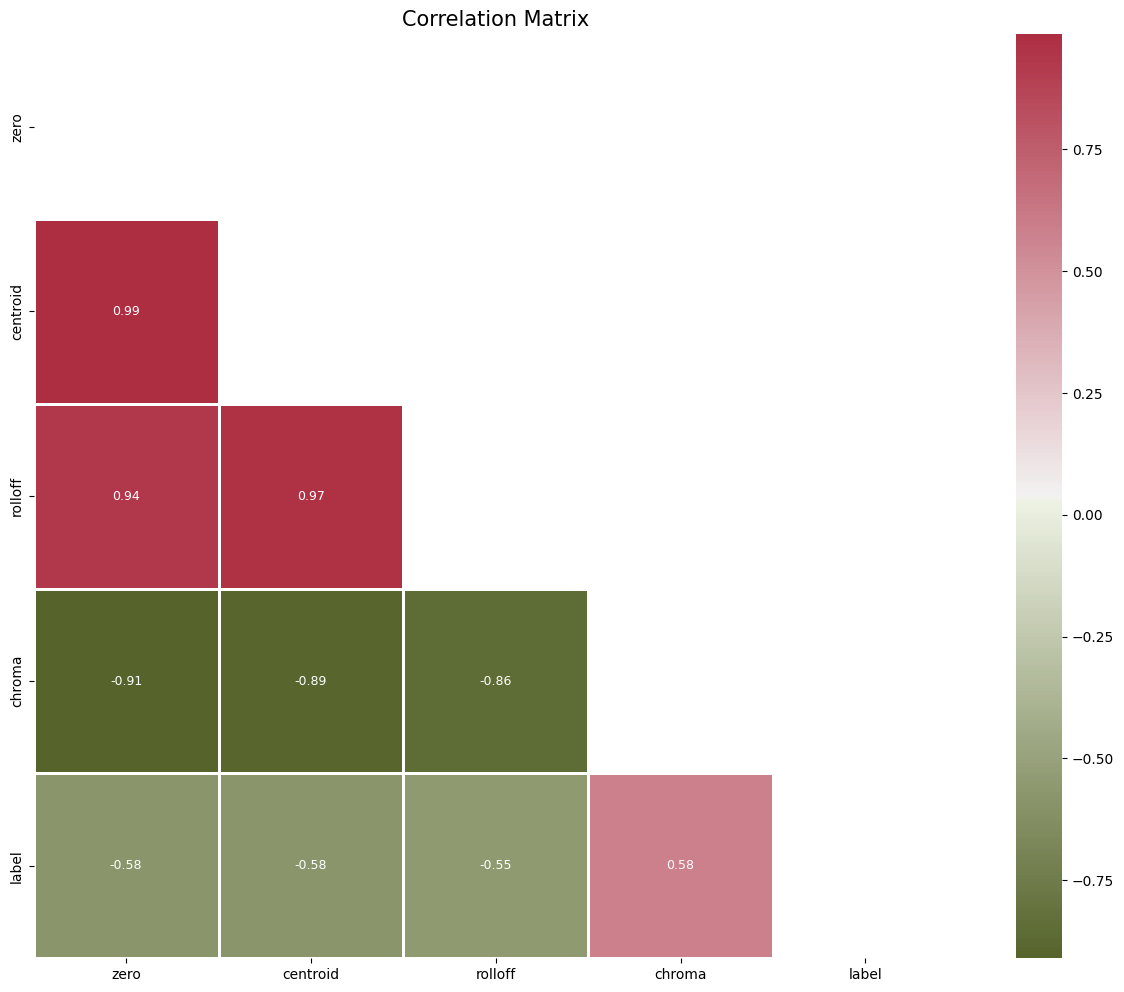

In [73]:
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)
mask = np.triu(np.ones_like(audio_df["zero,centroid,rolloff,chroma,label".split(',')].corr(), dtype=bool))        #makes one mask
plt.figure(figsize=(15, 12))

sns.heatmap(audio_df["zero,centroid,rolloff,chroma,label".split(',')].corr(), annot=True, cmap=cmap, fmt='.2f', mask = mask, linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

<div style="border-radius:10px; border:#87acde solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#87acde'>💡 Observations Post-Visualization:</font></h3>

* While tree-based models like Decision Trees, Random Forests, and Gradient Boosting Machines are generally robust to multicollinearity, it's still worth noting when certain features are highly correlated. In our heatmap, we observed that Roll off highly correlated with Centroid and zero higly related to centroi having similarity of almost 0.99 and 0.97 respectively, indicating they are essentially the same feature.

* Though correlation is less critical for tree-based models compared to linear models, we should still consider it during the feature selection process. Having features that are highly correlated can make our model unnecessarily complex. When two features have a high correlation, we can consider dropping one to simplify the model and potentially prevent overfitting.


- **Dropping Centroid to fix multicollinearity.**

In [76]:
if "centroid" in audio_df.columns:
    audio_df.drop("centroid", axis=1, inplace=True)
else:
    print("The column 'centroid' does not exist in the DataFrame.")


The column 'centroid' does not exist in the DataFrame.


In [77]:
num_var= audio_df["zero,rolloff,chroma".split(',')]

In [78]:
def plot_pair(df_train,num_var,target,plotname):
    '''
    Funtion to make a pairplot:
    df_train: total data
    num_var: a list of numeric variable
    target: target variable
    '''
    g = sns.pairplot(data=df_train, x_vars=num_var, y_vars=num_var, hue=target, corner=True)
    g._legend.set_bbox_to_anchor((0.8, 0.7))
    g._legend.set_title(target)
    g._legend.loc = 'upper center'
    g._legend.get_title().set_fontsize(14)
    for item in g._legend.get_texts():
        item.set_fontsize(14)

    plt.suptitle(plotname, ha='center', fontweight='bold', fontsize=25, y=0.98)
    plt.show()

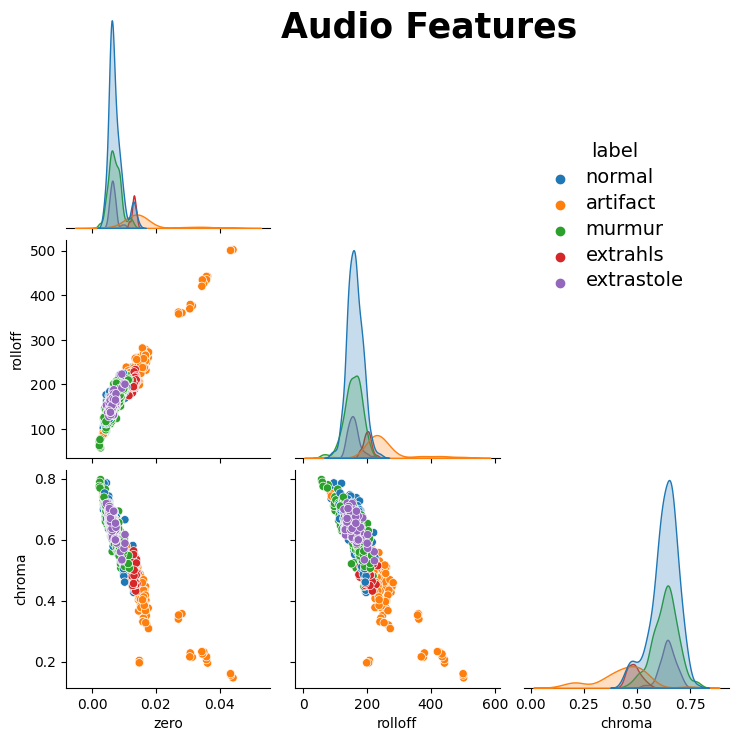

In [79]:
plot_pair(audio_df_cp, num_var, "label", "Audio Features")

In [80]:
audio_df.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc123,mfcc124,mfcc125,mfcc126,mfcc127,zero,rolloff,chroma,label,file
0,-527.21,72.24,66.99,61.88,54.81,46.86,38.66,30.43,22.84,16.18,...,0.01,0.03,0.01,-0.02,0.00,0.01,164.64,0.65,3,murmur_noisymurmur_243_1309197760898_C.wav_str...
1,-505.72,61.80,59.26,55.25,50.03,43.94,37.36,30.65,24.14,18.11,...,0.28,0.23,0.18,0.12,0.06,0.01,153.32,0.63,4,normal__126_1306777102824_B.wav_stretch_0.8
2,-541.84,65.32,62.13,57.88,52.52,46.28,39.46,32.50,25.79,19.56,...,0.35,0.28,0.22,0.16,0.09,0.01,151.28,0.64,4,normal__126_1306777102824_D.wav_stretch_0.8
3,-538.19,77.08,72.76,66.43,58.63,49.84,40.70,31.85,23.80,16.85,...,0.13,0.10,0.08,0.06,0.03,0.01,147.44,0.65,2,extrastole__220_1308250132896_B.wav_stretch_1.2
4,-499.62,43.80,42.75,41.39,39.67,37.54,35.07,32.36,29.45,26.41,...,0.01,0.01,0.00,0.00,0.00,0.00,62.61,0.78,3,murmur__201103291548.wav_stretch_0.8


In [81]:
audio_df.drop("file", axis=1, inplace= True)

In [82]:
X = audio_df.drop("label", axis=1)
y= audio_df.label

In [83]:
scaler = StandardScaler()

scaledX = scaler.fit_transform(X)

In [84]:
X_train, X_test, y_train,y_test = train_test_split(scaledX,y,random_state=42, train_size=0.8, shuffle=True)

In [85]:
X_train.shape , y_train.shape

((969, 131), (969,))

In [86]:
X_test.shape , y_test.shape

((243, 131), (243,))

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#4bce55; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🚀📈 Model Training and  Evalution:</p>

In [87]:
scores = cross_val_score(HistGradientBoostingClassifier(), X , y, cv=5)

In [88]:
scores

array([0.83950617, 0.86831276, 0.81404959, 0.83471074, 0.8553719 ])

In [89]:
scores.mean()

0.8423902322892222

In [90]:
model = HistGradientBoostingClassifier().fit(X_train,y_train)

In [92]:
y_pred = model.predict(X_test)

<h3>Accuracy score 

In [93]:
report_dict = classification_report(y_test, y_pred, output_dict= True)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.70      0.70      0.70        10
           2       0.71      0.29      0.42        17
           3       0.90      0.74      0.81        61
           4       0.78      0.92      0.84       121

    accuracy                           0.83       243
   macro avg       0.82      0.72      0.75       243
weighted avg       0.83      0.83      0.82       243



In [94]:
audio_df.label.value_counts()

label
4    648
3    306
0    120
2     93
1     45
Name: count, dtype: int64

In [95]:
ycp = y_test

In [96]:
y_pred = pd.Series(y_pred)
y_test = pd.Series(ycp)

In [97]:
y_test

801    4
677    4
43     1
990    3
70     4
      ..
904    4
673    4
708    2
367    4
464    3
Name: label, Length: 243, dtype: int64

In [98]:
y_pred = y_pred.map({4:"normal" , 3:"murmur" ,0: "artifact" , 2: "extrastole" , 1:"extrahls"})
y_test = y_test.map({4:"normal" , 3:"murmur" ,0: "artifact" , 2: "extrastole" , 1:"extrahls"})

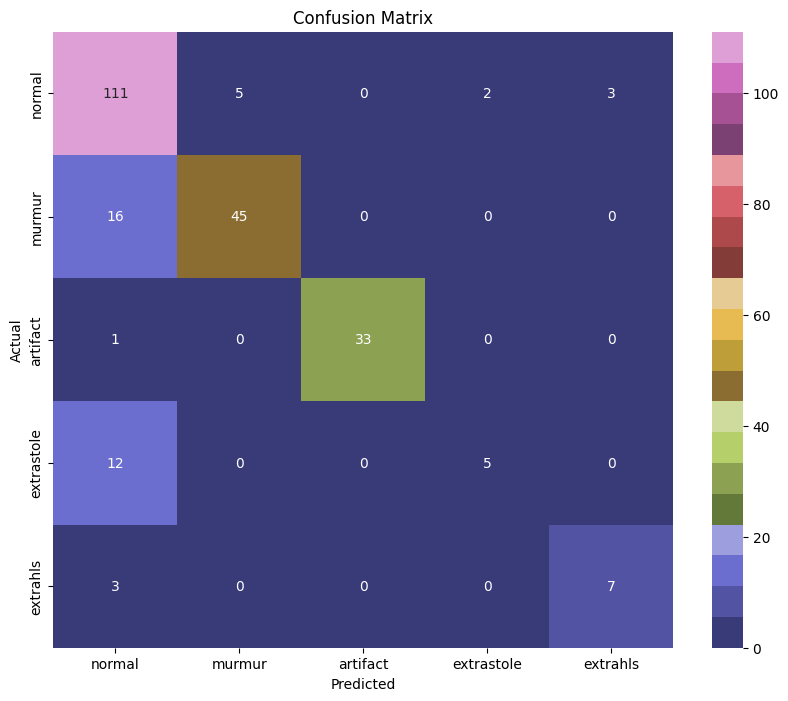

In [99]:
conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ["normal", "murmur", "artifact", "extrastole", "extrahls"]

conf_matrix = confusion_matrix(y_test, y_pred, labels=class_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap= "tab20b", cbar=True,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<div style="border-radius:10px; border:#4bce55 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#4bce55'>📕 Conclusion </font></h3>
    
  - Accuracy of 83.423 % and upto 86.68% on second cross validation score out of 5 folds was acheived using a basic HistBoostClassifier (not fined tuned)

### MODEL DUMPING

In [100]:
!pip install joblib
import joblib

filename = "hb.pkl"

joblib.dump(model, filename)


['hb.pkl']

<div style="border-radius:10px; border:#554bce solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 References:</font></h3>


* Best : https://www.kaggle.com/code/kajler/heartbeat-classification-random-forest-mlp , https://www.kaggle.com/code/brsdincer/heartbeat-sounds-classification-analysis#ANALYSIS
 
* Reads: https://www.kaggle.com/code/paoloripamonti/heartbeat-disease-classifier , 

* Intutive: https://www.kaggle.com/code/ahmederaky/audio-classification#Read-data-from-metadata-csv-file
 
* LSTM and EDA Guides :  https://www.kaggle.com/code/osamaheikal/heartbeat-sound-lstm-classification-96#EDA-and-Visualization

* Intial reference : https://www.kaggle.com/code/zzettrkalpakbal/heart-murmur-classification
- https://www.kaggle.com/code/ahmederaky/audio-classification#Loading-the-data ~ thought of one function
    
* My old notebooks: https://www.kaggle.com/aaradhyabadal/code
                  
 
